## Analysis of Arbuckle 2020, JNeuro, extensionflexion data
Ali Ghavampour 2024
alighavam79@gmail.com
aghavamp@uwo.ca

From Spencer's data I made two combined dataframes with `parse_EF_data.m` code. Take a look there and also paper methods for the details of the regressors and experiment. The data I will be using here are: `ef_glm_betas.mat` and `ef_glm_info.tsv`.

In [ ]:
! pip install statsmodels
! pip install pytest
! pip install numpy nibabel nilearn neuroimagingtools

In [1]:
import numpy as np
import PcmPy as pcm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io
import os
from scipy import stats
from statsmodels.stats.anova import AnovaRM


# Load the data
mat = scipy.io.loadmat(os.path.join('analysis','ef_glm_betas.mat'))
glm_betas = mat['glm_betas']
glm_betas = glm_betas[0,0]
glm_betas['beta'].shape
# checking the imported structure fields:
print(glm_betas.dtype.names)

glm_info = pd.read_csv(os.path.join('analysis','ef_glm_info.tsv'), sep='\t')

('beta', 'ResMs', 'xyz', 'sn', 'region', 'region_name', 'hemi')


## Mean activation across conditions

/var/folders/5y/1pn48fgn7yb77gc17h_5jms80000gp/T/ipykernel_36689/3913206664.py:34: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ana = pd.concat([ana, c], ignore_index=True)


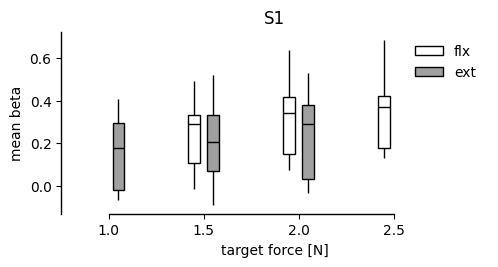

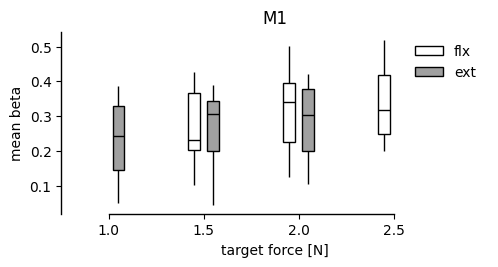

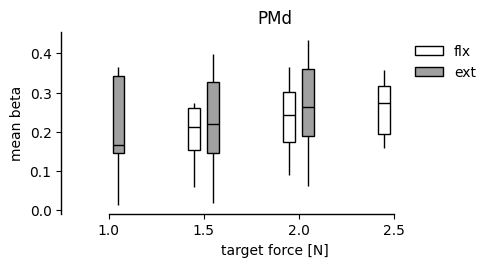

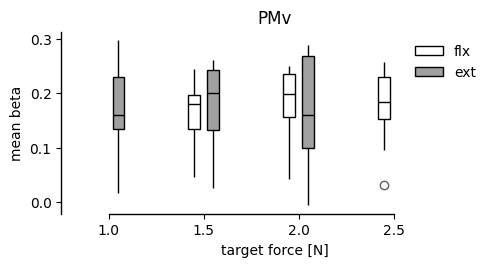

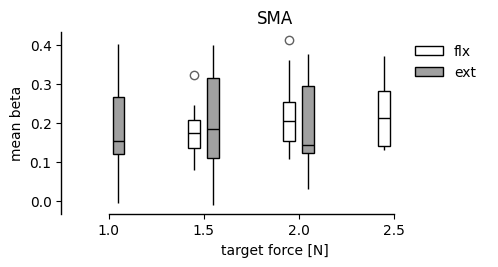

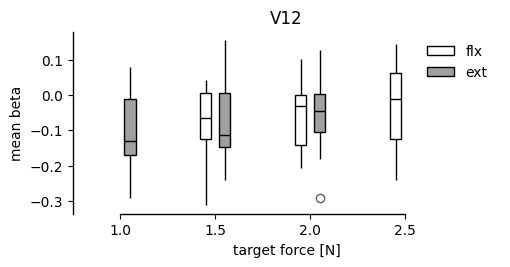

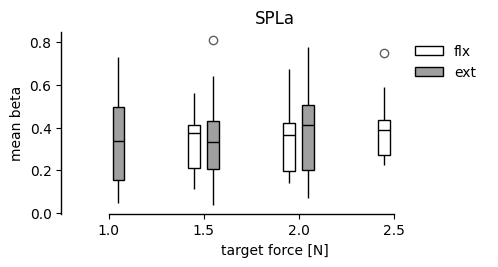

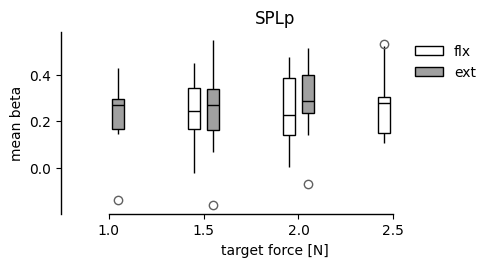

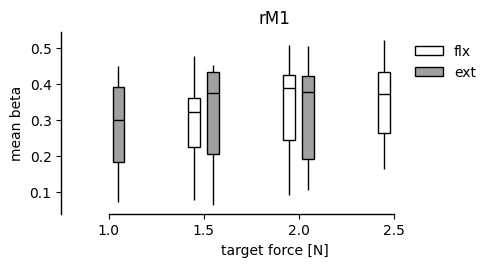

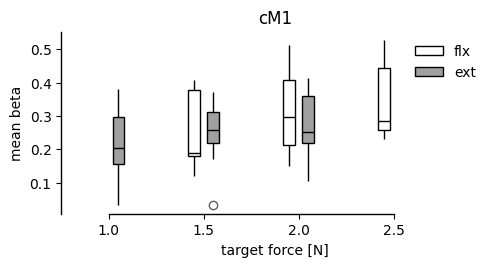


S1, flexion
         F Value  Num DF  Den DF    Pr > F
force  43.532536     2.0    16.0  0.000000

S1, extension
         F Value  Num DF  Den DF    Pr > F
force  17.967721     2.0    16.0  0.000081

M1, flexion
         F Value  Num DF  Den DF    Pr > F
force  25.347444     2.0    16.0  0.000011

M1, extension
         F Value  Num DF  Den DF    Pr > F
force  11.288014     2.0    16.0  0.000876

PMd, flexion
         F Value  Num DF  Den DF    Pr > F
force  16.378690     2.0    16.0  0.000134

PMd, extension
        F Value  Num DF  Den DF    Pr > F
force  6.054850     2.0    16.0  0.011018

PMv, flexion
        F Value  Num DF  Den DF    Pr > F
force  1.683599     2.0    16.0  0.216983

PMv, extension
        F Value  Num DF  Den DF    Pr > F
force  0.589400     2.0    16.0  0.566262

SMA, flexion
         F Value  Num DF  Den DF    Pr > F
force  11.562983     2.0    16.0  0.000782

SMA, extension
        F Value  Num DF  Den DF    Pr > F
force  0.815683     2.0    16.0  0.459909

V

In [3]:
beta = glm_betas['beta'] / np.sqrt(glm_betas['ResMs'])

# region info:
region_names = ['S1','M1','PMd','PMv','SMA','V12','SPLa','SPLp','rM1','cM1']
region = [1,2,3,4,5,6,7,8,9,10]

sn = np.unique(glm_info['sn'])
force = np.unique(glm_info['targetforce'])
dir = [1,2] # 1 = flexion, 2 = extension

ana = pd.DataFrame(columns=['region','sn','force','dir','meanAct'])
for reg in region:
    for s in sn:
        # get the glm regressor info for subject s:
        sn_info = glm_info[glm_info['sn']==s].reset_index()
        # choose the region voxels of the subject:
        rows = ((glm_betas['sn']==s) & (glm_betas['region']==reg)).flatten()
        for f in force:
            for d in dir:
                # choose the appropariate glm regressors:
                columns = (sn_info['targetforce']==f) & (sn_info['dirPressed']==d).values.flatten()
                if sum(columns)==0:
                    # because for example, flexion does not have 1N press force
                    continue
                
                # get the beta values:
                tmp_beta = beta[rows,:][:,columns]

                # mean activity:
                meanAct = np.mean(tmp_beta)

                # add the info to the dataframe:
                c = pd.DataFrame({'region': [reg], 'sn': [s], 'force': [f], 'dir': [d], 'meanAct': [meanAct]})
                ana = pd.concat([ana, c], ignore_index=True)

# Define custom properties for the box plot
boxprops = dict(edgecolor='#000000', linewidth=1)
whiskerprops = dict(color='#000000', linewidth=1)
capprops = dict(visible=False)  # Remove the caps
medianprops = dict(color='#000000', linewidth=1)

for reg in region:
    tmp_ana = ana[ana['region']==reg]
    # box plot:
    cm = 1/2.54  # centimeters in inches
    fig, ax = plt.subplots(figsize=(14*cm, 6*cm))
    sns.boxplot(x='force', y='meanAct', hue='dir', data=tmp_ana, dodge=True, width=0.4, palette=["#ffffff", "#a0a0a0"], gap=0.4,
                boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops, medianprops=medianprops)
    
    plt.title(region_names[reg-1])

    ax.set_xlim([-0.5, 4])
    ax.set_xlabel('target force [N]')
    ax.set_ylabel('mean beta')
    handles, _ = ax.get_legend_handles_labels()
    ax.legend(handles=handles, labels=['flx','ext'], loc='upper right', frameon=False)

    # Make it pretty:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1)
    ax.spines['bottom'].set_linewidth(1)

    ax.spines["left"].set_bounds(ax.get_ylim()[0], ax.get_ylim()[-1])
    ax.spines["bottom"].set_bounds(ax.get_xticks()[0], ax.get_xticks()[-1])

    plt.show()

    # save the figures:
    fig.savefig(os.path.join('figures',f'ef_mean_region_{region_names[reg-1]}.pdf'), format='pdf', bbox_inches='tight')


# ======================== STATS ========================
# rm-ANOVA on flexion across force levels:
for reg in region:
    tmp_flx = ana[(ana['region']==reg) & (ana['dir']==1)].reset_index()
    tmp_ext = ana[(ana['region']==reg) & (ana['dir']==2)].reset_index()

    # rm-ANOVA:
    anova_flx = AnovaRM(data=tmp_flx, depvar='meanAct', subject='sn', within=['force']).fit()
    table = anova_flx.anova_table
    table['Pr > F'] = table['Pr > F'].apply(lambda p: f'{p:.6f}')
    table['F Value'] = table['F Value'].apply(lambda f: f'{f:.6f}')
    print(f'\n{region_names[reg-1]}, flexion')
    print(table)

    anova_ext = AnovaRM(data=tmp_ext, depvar='meanAct', subject='sn', within=['force']).fit()
    table = anova_ext.anova_table
    table['Pr > F'] = table['Pr > F'].apply(lambda p: f'{p:.6f}')
    table['F Value'] = table['F Value'].apply(lambda f: f'{f:.6f}')
    print(f'\n{region_names[reg-1]}, extension')
    print(table)
    print('=====================')
    

## Estimating reliability of the data

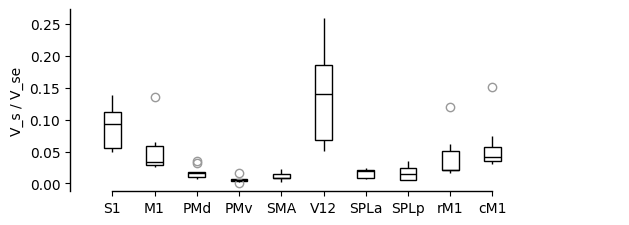

In [ ]:
from utils import dataset as ds
import importlib
importlib.reload(ds)

region_names = ['S1','M1','PMd','PMv','SMA','V12','SPLa','SPLp','rM1','cM1']
region = [1,2,3,4,5,6,7,8,9,10]

snr = []
for reg in region:
    reg_idx = (glm_betas['region']==reg).flatten()
    beta = glm_betas['beta'][reg_idx] / np.sqrt(glm_betas['ResMs'][reg_idx])
    beta = beta.T
    subj_vec = glm_betas['sn'][reg_idx].flatten()

    partition_vec = glm_info[glm_info['sn']==1]['run'].values.flatten()
    cond_vec = glm_info[glm_info['sn']==1]['tt'].values.flatten()

    v_s, v_se = ds.within_subj_var(data = beta, partition_vec=partition_vec, cond_vec=cond_vec, subj_vec=subj_vec, subtract_mean=True)
    snr.extend(v_s / v_se)

region_indicator = np.repeat(np.array(region),9)
snr = np.array(snr)

cm = 1/2.54  # centimeters in inches
fig, ax = plt.subplots(figsize=(18*cm, 6*cm))

# Define custom properties for the box plot
boxprops = dict(edgecolor='#000000', linewidth=1)
whiskerprops = dict(color='#000000', linewidth=1)
capprops = dict(visible=False)  # Remove the caps
medianprops = dict(color='#000000', linewidth=1)

sns.boxplot(x=region_indicator, y=snr, dodge=True, width=0.4, color='#ffffff',
            boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops, medianprops=medianprops)

ax.set_xlim([-1, 12])
ax.set_xticks(np.arange(0,10))
ax.set_xticklabels(region_names)
ax.set_ylabel('V_s / V_se')

# Make it pretty:
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1)
ax.spines['bottom'].set_linewidth(1)

ax.spines["left"].set_bounds(ax.get_ylim()[0], ax.get_ylim()[-1])
ax.spines["bottom"].set_bounds(ax.get_xticks()[0], ax.get_xticks()[-1])

plt.savefig(os.path.join('figures','ef_snr.pdf'), format='pdf', bbox_inches='tight')

plt.show()

## Covariance in different regions

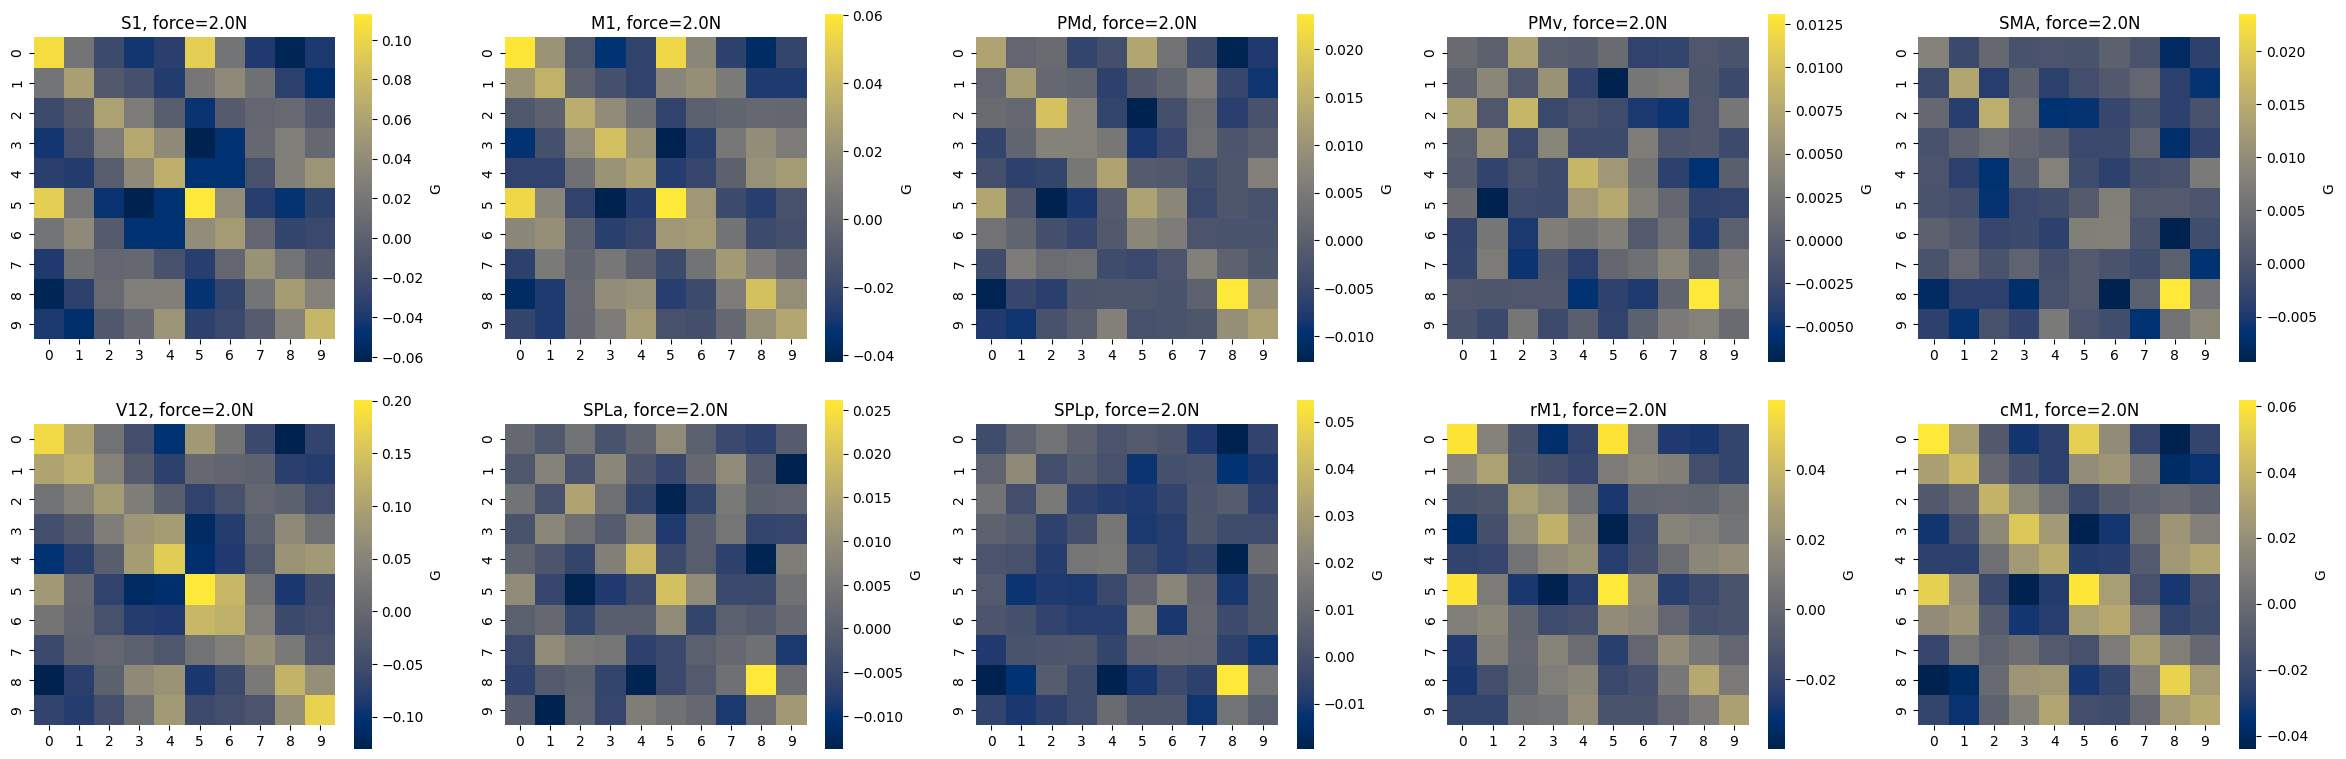

In [ ]:
beta = glm_betas['beta'] / np.sqrt(glm_betas['ResMs'])

# region info:
region_names = ['S1','M1','PMd','PMv','SMA','V12','SPLa','SPLp','rM1','cM1']
region = [1,2,3,4,5,6,7,8,9,10]

sn = np.unique(glm_info['sn'])
force = np.unique(glm_info['targetforce'])
f = force[2]
# Estimate and plot the second moment matrices
N=sn.shape[0]
G_hat = np.zeros((N,len(region),10,10))
for reg in region:
    for s in sn:
        voxel_idx = ((glm_betas['region']==reg) & (glm_betas['sn']==s)).flatten()
        regressor_idx = (glm_info[glm_info['sn']==s]['targetforce']==f).values.flatten()
        Y = beta[voxel_idx,:][:,regressor_idx].T

        partition_vec = glm_info[(glm_info['sn']==s) & (glm_info['targetforce']==f)]['run'].values.flatten()
        cond_vec = glm_info[(glm_info['sn']==s) & (glm_info['targetforce']==f)]['tt'].values.flatten()
        
        G_hat[s-1,reg-1,:,:],_ = pcm.est_G_crossval(Y,
                                                    cond_vec,
                                                    partition_vec,
                                                    X=pcm.matrix.indicator(partition_vec))

# average G across subjects:
G_avg = G_hat.mean(axis=0)

# plot the second moment matrices:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(60*cm, 20*cm))

cm = 1/2.54  # centimeters in inches
for i, ax in enumerate(axes.flat):
    sns.heatmap(G_avg[i,:,:], cmap='cividis', square=True, cbar_kws={'label': 'G'}, ax=ax)
    ax.set_title(f'{region_names[i]}, force={f}N')

plt.tight_layout()
plt.savefig(os.path.join('figures','ef_avgG_force_2N.pdf'), format='pdf', bbox_inches='tight')
plt.show()

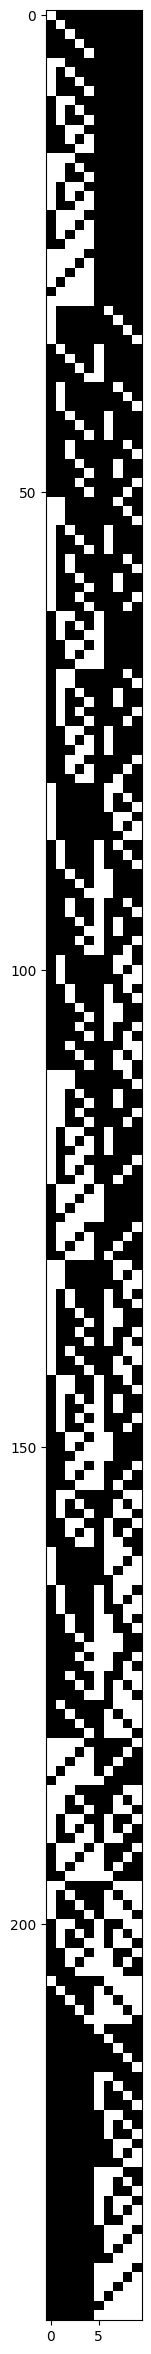

In [11]:
import numpy as np
import PcmPy as pcm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io
from itertools import permutations

def generate_all_chords():
    # Ali Ghavampour 2024 - alighavam79@gmail.com
    # This function generates all of the possible chords

    comb_pool = [
        [1, 9, 9, 9, 9],  # All the possible combinations of flex-ext-relax. All permutations of each combination makes all possible chords.
        [2, 9, 9, 9, 9],
        [1, 1, 9, 9, 9],
        [1, 2, 9, 9, 9],
        [2, 2, 9, 9, 9],
        [1, 1, 1, 9, 9],
        [1, 1, 2, 9, 9],
        [1, 2, 2, 9, 9],
        [2, 2, 2, 9, 9],
        [1, 1, 1, 1, 9],
        [1, 1, 1, 2, 9],
        [1, 1, 2, 2, 9],
        [1, 2, 2, 2, 9],
        [2, 2, 2, 2, 9],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 2],
        [1, 1, 1, 2, 2],
        [1, 1, 2, 2, 2],
        [1, 2, 2, 2, 2],
        [2, 2, 2, 2, 2]
    ]

    chord_mat = np.array([[9, 9, 9, 9, 9]])  # chords are saved in this matrix (243x5).
    chord_vec = []  # we should turn the 243x5 matrix into a 243x1 string vector for the .tgt files.

    # making a 243x13 matrix of all the possible chords:
    for comb in comb_pool:
        chord_tmp_mat = np.array(list(permutations(comb)))
        chord_mat = np.vstack((chord_mat, np.unique(chord_tmp_mat, axis=0)))

    # change the matrix into a vector -> each row of matrix will become an element of the new vector:
    chord_mat = chord_mat.astype(str)
    for row in chord_mat:
        tmp = ''.join(row)
        tmp = int(tmp)
        chord_vec.append(tmp)

    chord_vec = chord_vec[1:]  # chordVec contains all the possible unique chords other than 99999 (size:242x1) which is all fingers relaxed.
    return chord_vec

def make_design(chord_vec):
    # Ali Ghavampour 2024

    # sort the chords to flexion-only, mixed, and extension-only:
    flex_only = []
    ext_only = []
    mixed = []
    for chord in chord_vec:
        chord_str = str(chord)
        includes_1 = '1' in chord_str
        includes_2 = '2' in chord_str
        if includes_1 and not includes_2:
            flex_only.append(chord)
        elif includes_2 and not includes_1:
            ext_only.append(chord)
        else:
            mixed.append(chord)
    
    sorted_chords = flex_only + mixed + ext_only

    # make the design matrix:
    X = np.zeros((242,10), dtype=int)
    for i,chord in enumerate(sorted_chords):
        chord_str = str(chord)
        # flexion regressors:
        X[i,:5] = [1 if char == '1' else 0 for char in chord_str]
        # extension regressors:
        X[i,5:] = [1 if char == '2' else 0 for char in chord_str]
    
    return X

# Example usage
chord_vec = generate_all_chords()
X = make_design(chord_vec)

# show the design matrix:
plt.figure(figsize=(30,30))
plt.imshow(X, cmap='gray')
plt.show()

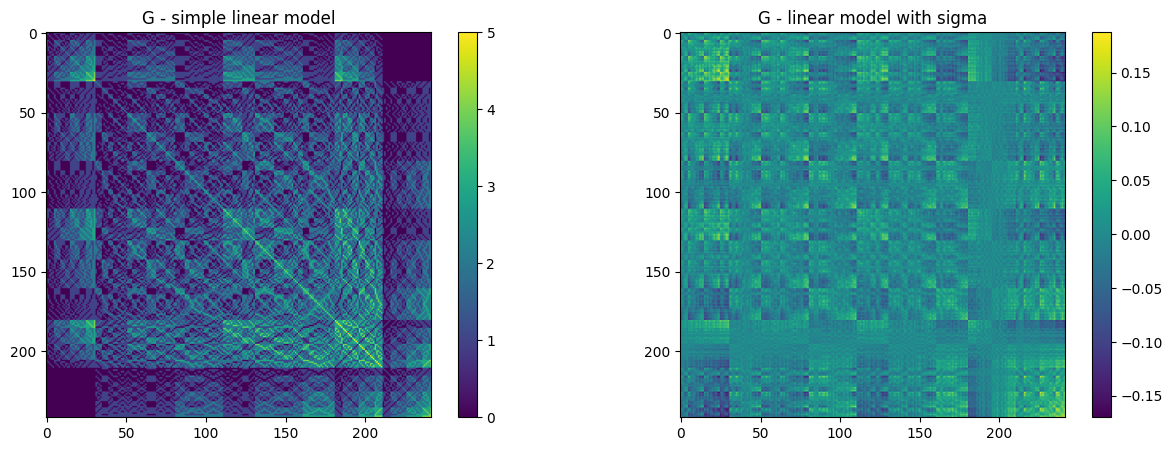

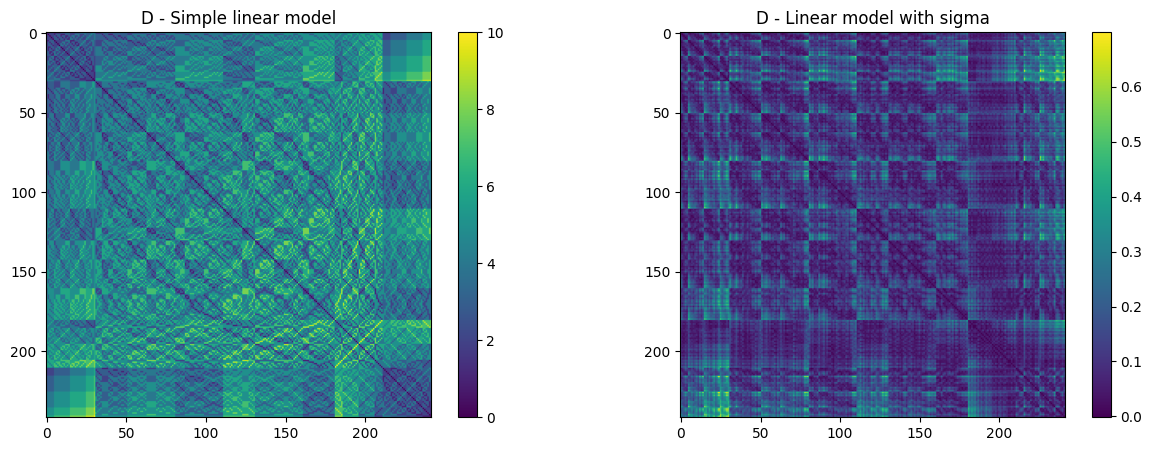

In [17]:
# simple linear model prediction:
G1 = X @ X.T

# linear model with sigma added:
sigma = G_hat.mean(axis=0)
G2 = X @ sigma @ X.T

# show the second moment matrices:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(G1, cmap='viridis')
plt.colorbar()
plt.title('G - simple linear model')

plt.subplot(1,2,2)
plt.imshow(G2, cmap='viridis')
plt.colorbar()
plt.title('G - linear model with sigma')
plt.show()


D1 = pcm.G_to_dist(G1)
D2 = pcm.G_to_dist(G2)
# show the second moment matrices:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(D1, cmap='viridis')
plt.colorbar()
plt.title('D - Simple linear model')

plt.subplot(1,2,2)
plt.imshow(D2, cmap='viridis')
plt.colorbar()
plt.title('D - Linear model with sigma')
plt.show()